<a href="https://www.kaggle.com/code/nkosibking/reddit-comments-rules-classification?scriptVersionId=252163028" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Import necessary libraries
import pandas as pd

# Load the datasets
try:
    train_df = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/train.csv')
    test_df = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/test.csv')
    sample_submission_df = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/sample_submission.csv')

    print("Data loaded successfully!")
    print("\nTraining data head:")
    # Showing the correct text column 'body'
    print(train_df[['row_id', 'body', 'rule_violation']].head())
    print("\nTraining data info:")
    train_df.info()

    print("\nTest data head:")
    # Showing the correct text column 'body'
    print(test_df[['row_id', 'body']].head())
    print("\nTest data info:")
    test_df.info()

    print("\nSample Submission head:")
    print(sample_submission_df.head())

except FileNotFoundError:
    print("Error: Make sure 'train.csv', 'test.csv', and 'sample_submission.csv' are in the same directory.")
except Exception as e:
    print(f"An error occurred while loading data: {e}")



Data loaded successfully!

Training data head:
   row_id                                               body  rule_violation
0       0  Banks don't want you to know this! Click here ...               0
1       1  SD Stream [ ENG Link 1] (http://www.sportsstre...               0
2       2  Lol. Try appealing the ban and say you won't d...               1
3       3  she will come your home open her legs with  an...               1
4       4  code free tyrande --->>> [Imgur](http://i.imgu...               1

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_id              2029 non-null   int64 
 1   body                2029 non-null   object
 2   rule                2029 non-null   object
 3   subreddit           2029 non-null   object
 4   positive_example_1  2029 non-null   object
 5   positive_example_2  202

Text Preprocessing 

In [2]:
import re
import nltk
from nltk.corpus import stopwords



# Get English stopwords
stop_words = set(stopwords.words('english'))


from nltk.stem import WordNetLemmatizer


lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words] # Apply lemmatization
    text = ' '.join(words)
    return text


# Define the preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return "" # Handle non-string inputs gracefully, e.g., NaNs in 'body'
    text = text.lower() # Lowercase the text
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove punctuation and numbers
    words = text.split() # Tokenize
    words = [word for word in words if word not in stop_words] # Remove stopwords
    text = ' '.join(words) # Join words back into a string
    return text


print("Applying preprocessing to training data...")

train_df['processed_text'] = train_df['body'].apply(preprocess_text)
print("Preprocessing applied to training data.")

print("\nApplying preprocessing to test data...")

test_df['processed_text'] = test_df['body'].apply(preprocess_text)
print("Preprocessing applied to test data.")

print("\nTraining data with processed text head:")
print(train_df[['body', 'processed_text', 'rule_violation']].head())

print("\nTest data with processed text head:")

print(test_df[['body', 'processed_text']].head())


Applying preprocessing to training data...
Preprocessing applied to training data.

Applying preprocessing to test data...
Preprocessing applied to test data.

Training data with processed text head:
                                                body  \
0  Banks don't want you to know this! Click here ...   
1  SD Stream [ ENG Link 1] (http://www.sportsstre...   
2  Lol. Try appealing the ban and say you won't d...   
3  she will come your home open her legs with  an...   
4  code free tyrande --->>> [Imgur](http://i.imgu...   

                                      processed_text  rule_violation  
0                    banks dont want know click know               0  
1  sd stream eng link httpwwwsportsstreamscomastr...               0  
2                     lol try appealing ban say wont               1  
3                come home open legs httpshorsitpali               1  
4  code free tyrande imgurhttpiimgurcomklvssclpng...               1  

Test data with processed text head:


Feature Extraction with RNN

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define parameters for tokenization and sequencing
max_words = 10000  # Max number of words to keep based on frequency
maxlen = 100       # Max length of sequences (comments). Shorter will be padded, longer truncated.

# Initialize the Tokenizer
print("Initializing Tokenizer...")
tokenizer = Tokenizer(num_words=max_words, oov_token="<unk>") # <unk> for out-of-vocabulary words

# Fit the tokenizer on the training data's processed text
# This builds the vocabulary
print("Fitting Tokenizer on training data...")
tokenizer.fit_on_texts(train_df['processed_text'])
print("Tokenizer fitted.")

# Get the vocabulary size (number of unique words plus 1 for padding/Oov)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Convert text to sequences of integers
print("Converting training text to sequences...")
X_train_sequences = tokenizer.texts_to_sequences(train_df['processed_text'])
print("Converting test text to sequences...")
X_test_sequences = tokenizer.texts_to_sequences(test_df['processed_text'])

# Pad the sequences to ensure uniform length
print(f"Padding sequences to maxlen={maxlen}...")
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')
print("Sequences padded.")

# Define the target variable for training
y_train = train_df['rule_violation']

print(f"\nShape of X_train_padded: {X_train_padded.shape}")
print(f"Shape of X_test_padded: {X_test_padded.shape}")
print(f"Shape of y_train: {y_train.shape}")

print("\nRNN-specific feature extraction complete.")


2025-07-24 01:42:46.892529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753321367.212655      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753321367.303979      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Initializing Tokenizer...
Fitting Tokenizer on training data...
Tokenizer fitted.
Vocabulary size: 7679
Converting training text to sequences...
Converting test text to sequences...
Padding sequences to maxlen=100...
Sequences padded.

Shape of X_train_padded: (2029, 100)
Shape of X_test_padded: (10, 100)
Shape of y_train: (2029,)

RNN-specific feature extraction complete.


Model Definition and Training 

Building the RNN (LSTM) model...
Compiling the model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-07-24 01:43:06.581484: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model compiled.

Training the model for 5 epochs with batch size 32...
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - auc: 0.5260 - loss: 0.6923 - val_auc: 0.5000 - val_loss: 0.6938
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - auc: 0.4779 - loss: 0.6951 - val_auc: 0.5000 - val_loss: 0.6933
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - auc: 0.4900 - loss: 0.6937 - val_auc: 0.5000 - val_loss: 0.6935
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - auc: 0.4649 - loss: 0.6959 - val_auc: 0.5000 - val_loss: 0.6950
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - auc: 0.4575 - loss: 0.6952 - val_auc: 0.5000 - val_loss: 0.6898
Model training complete.


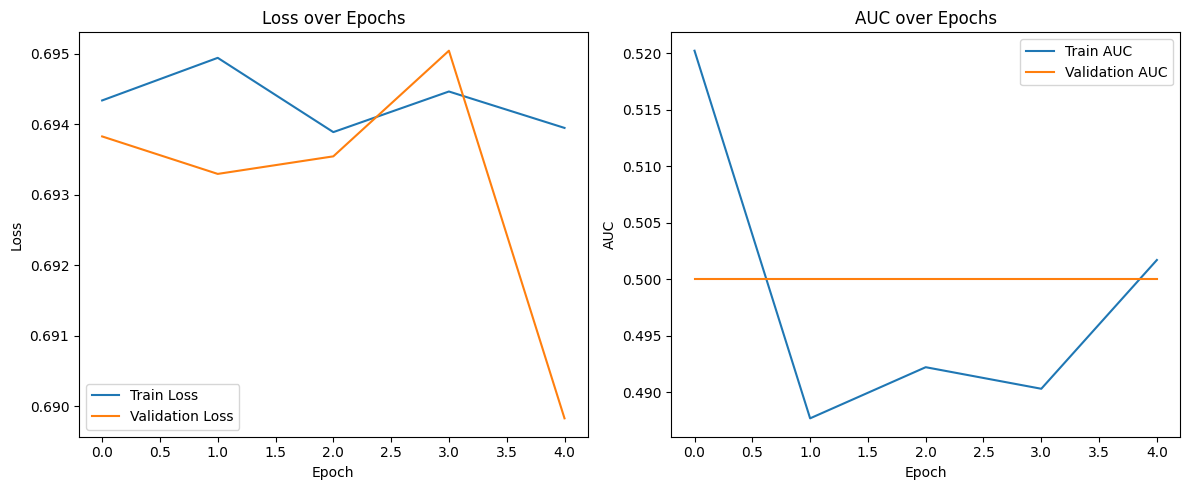

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define model parameters
embedding_dim = 128  # Dimension of the dense embedding
lstm_units = 128     # Number of LSTM units
epochs = 5           # Number of training epochs (start low, can increase)
batch_size = 32      # Number of samples per gradient update

# Build the Sequential Model
print("Building the RNN (LSTM) model...")
model = Sequential([
    # Embedding layer: Turns positive integers (word IDs) into dense vectors of fixed size.
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    # LSTM layer: The core RNN layer to learn sequential patterns.
    LSTM(units=lstm_units, return_sequences=False), # return_sequences=False for classification output
    # Dropout layer: Helps prevent overfitting by randomly setting a fraction of inputs to 0.
    Dropout(0.5),
    # Dense output layer: Single neuron with sigmoid activation for binary classification.
    Dense(1, activation='sigmoid')
])

# Compile the model
print("Compiling the model...")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(name='auc')])

# Print model summary
model.summary()
print("Model compiled.")

# Train the model
print(f"\nTraining the model for {epochs} epochs with batch size {batch_size}...")
history = model.fit(
    X_train_padded, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2, # Use 20% of training data for validation
    verbose=1 # Show progress bar during training
)
print("Model training complete.")

# You can plot training history to see loss and AUC over epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


Prediction and Submission 

In [5]:
# Make predictions on the preprocessed test data
# The model directly outputs probabilities for the positive class
print("Generating predictions on the test data...")
predictions = model.predict(X_test_padded).flatten() # .flatten() converts shape (N,1) to (N,)
print("Predictions generated.")

# Create the submission DataFrame
submission_df = sample_submission_df.copy()

# Assign the predictions to the 'prediction' column
submission_df['prediction'] = predictions

# Display the first few rows of the submission file
print("\nSubmission file head:")
print(submission_df.head())

# Save the submission file
submission_file_name = 'submission_rnn.csv' # Changed filename to reflect RNN model
submission_df.to_csv(submission_file_name, index=False)

print(f"\nSubmission file '{submission_file_name}' created successfully!")
print("You can now submit this file to the Kaggle competition.")


Generating predictions on the test data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
Predictions generated.

Submission file head:
   row_id  rule_violation  prediction
0    2029             0.5    0.521541
1    2030             0.5    0.521541
2    2031             0.5    0.521541
3    2032             0.5    0.521541
4    2033             0.5    0.521541

Submission file 'submission_rnn.csv' created successfully!
You can now submit this file to the Kaggle competition.
